# Information
Authors: Shreyans Patel (SSP210009), Siddhant Medar (SSM200002), Pranitha Sreethar (PXS200095) and Adithya Iyer (ASI200000)

References:

[1] https://numpy.org/doc/

[2] https://pandas.pydata.org/pandas-docs/stable/

[3] https://matplotlib.org/stable/users/index.html

[4] https://seaborn.pydata.org/api.html 

[5] https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html 

[6] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html 

[7] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html 

[8] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

In [7]:
# Library Imports
import numpy as npy
import pandas as pds
import matplotlib.pyplot as matplt
import seaborn as sbrn

# Imports from Libraries
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Data Loaded Successfully

Google Stock Price Data Set has 252 data points with 7 variables each.

The data is as follows:

            Date         Open         High          Low        Close  \
0    2021-04-23  2283.469971  2325.820068  2278.209961  2315.300049   
1    2021-04-26  2319.929932  2341.260010  2313.840088  2326.739990   
2    2021-04-27  2336.000000  2337.449951  2304.270020  2307.120117   
3    2021-04-28  2407.145020  2452.377930  2374.850098  2379.909912   
4    2021-04-29  2410.330078  2436.520020  2402.280029  2429.889893   
..          ...          ...          ...          ...          ...   
247  2022-04-14  2612.989990  2614.205078  2542.229980  2545.060059   
248  2022-04-18  2548.199951  2574.239990  2531.569092  2559.219971   
249  2022-04-19  2561.540039  2618.074951  2549.030029  2610.620117   
250  2022-04-20  2625.679932  2638.469971  2557.881104  2564.909912   
251  2022-04-21  2587.000000  2606.149902  2493.000000  2498.750000   

       Adj Close   Volu

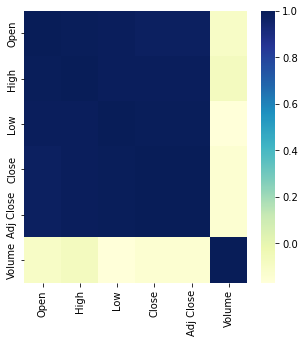

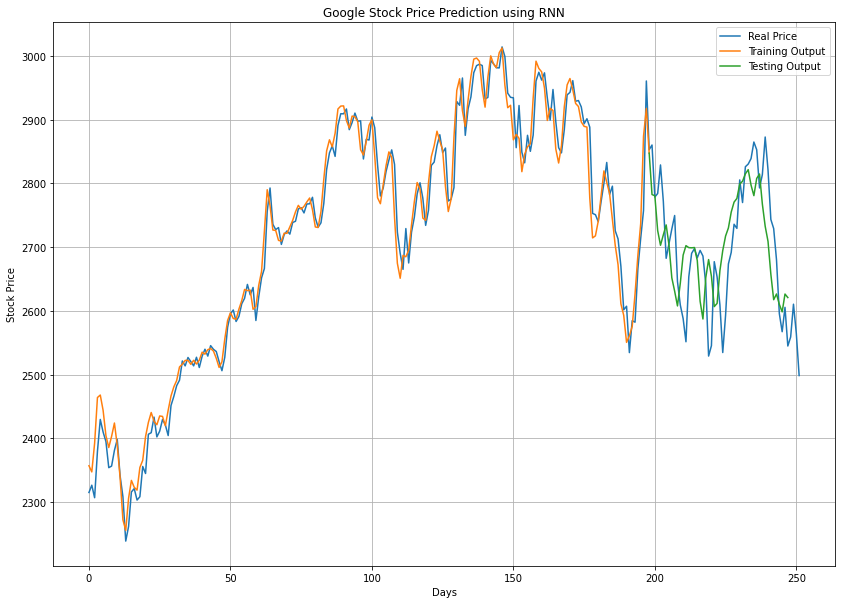

In [10]:
class RNN:
    def __init__(self, iDataFile):
        self.rawInput = pds.DataFrame(pds.read_csv(iDataFile))

        # Loaded Successfully
        print("Data Loaded Successfully\n")
        print("Google Stock Price Data Set has {} data points with {} variables each.\n".format(*self.rawInput.shape))
        print("The data is as follows:\n\n", self.rawInput)

    #------------------------------Helper Functions------------------------------#
    # TanH Activation Function with Derivative
    def tanHActivation(self, iInput, iDifferentitate = False):
        if(False == iDifferentitate):
            return npy.tanh(iInput)
        else:
            return (1 - npy.square(npy.tanh(iInput)))

    # Sigmoid Activation Function with Derivative
    def sigmoidActivation(self, iInput, iDifferentitate = False):
        if(False == iDifferentitate):
            return (1 / (1 + npy.exp(-iInput)))
        else:
            return (npy.exp(-iInput)) / ((npy.exp(-iInput) + 1) ** 2)

    # Relu Activation Function with Derivative
    def reluActivation(self, iInput, iDifferentitate = False):
        if(False == iDifferentitate):
            return npy.maximum(iInput, 0)
        else:
            return (iInput > 0)

    # Loss calculated in terms of mean squared error
    def calculateLoss(self, iActual, iPredicted):
        return npy.mean(npy.square(iActual - iPredicted))

    # Forward Propagation Function
    def forwardPropagation(self, iXInput):
        # List of hidden states prepared for giving the output after a forward pass
        oHiddenStates = []
        oHiddenStates.append(npy.zeros((self.hiddenNeurons, 1)))
        
        # Forward pass start step
        tStep = 0
        
        # Forward pass for all steps
        while(tStep < iXInput.shape[0]):
            # Get sum of weights
            tWeightsSum = (self.inputToHiddenWeights @ iXInput[[tStep]].T) + (self.hiddenToOutputWeights @ oHiddenStates[-1])
            
            # Go to the next hidden stage
            tNextHiddenStage = self.activationFunction(tWeightsSum)
            
            # Save the next stage
            oHiddenStates.append(tNextHiddenStage)
            
            # Increment Step
            tStep = tStep + 1
        
        # Forward pass output
        oHiddenOutput = self.hiddenToHiddenWeights @ oHiddenStates[-1]
        
        return oHiddenStates, oHiddenOutput
    
    # Backward Propagation Function
    def backwardPropagation(self, iXInput, iYOutput, iHiddenStates, iHiddenOutput):
        # Calculate Loss
        tLoss = self.calculateLoss(iYOutput, iHiddenOutput)
        
        # Initialize weights with retaining original shape
        tInputToHiddenWeights = npy.zeros(self.inputToHiddenWeights.shape)
        tHiddenToHiddenWeights = npy.zeros(self.hiddenToHiddenWeights.shape)
        tHiddenToOutputWeights = npy.zeros(self.hiddenToOutputWeights.shape)
        
        # Error Slope w.r.t Hidden to Hidden Layer Weights
        tErrorSlope = npy.dot(self.hiddenToHiddenWeights.T, tLoss)
        
        # Slope of tanH derivative w.r.t Hidden State
        tHiddenStatesSlope = tErrorSlope * self.activationFunction(iHiddenStates[-1], iDifferentitate = True)
        
        # Go backward through the states step by step
        for tStep in reversed(range(iXInput.shape[0])):
            # Update the weights by adding the Error Slopes
            tTemp = tHiddenStatesSlope @ iHiddenStates[tStep-1].T
            tHiddenToOutputWeights = tHiddenToOutputWeights + tTemp
            tTemp = tHiddenStatesSlope @ iXInput[[tStep-1]]
            tInputToHiddenWeights = tInputToHiddenWeights + tTemp

        # Update the weights by adding the Error Slopes
        tTemp = (iHiddenOutput - iYOutput) @ iHiddenStates[-1].T
        tHiddenToHiddenWeights = tHiddenToHiddenWeights + tTemp

        # Update the old original weights with the new weights
        self.inputToHiddenWeights = self.inputToHiddenWeights - self.learningRate * tInputToHiddenWeights
        self.hiddenToHiddenWeights = self.hiddenToHiddenWeights - self.learningRate * tHiddenToHiddenWeights
        self.hiddenToOutputWeights = self.hiddenToOutputWeights - self.learningRate * tHiddenToOutputWeights

    #-----------------------------------END----------------------------------------#
    
    # Preprocessing Stage
    def preprocess(self):
        print("\nPre-Processing the Data:\n")
        self.processedData = self.rawInput

        #-------------------------Check for Invalid Entries---------------------------#
        # Check for null values in the dataframe
        print("Null entries found?:", ("No\n" if self.processedData.isnull().sum().sum() == 0 else "Yes\n"))

        # Check for duplicate values in the dataframe
        print("Duplicate entries found?:", ("No\n" if self.processedData.duplicated().sum() == 0 else "Yes\n"))

        # Check if there is any categorical values
        print("Check for categorical values:\n")
        print(self.processedData.dtypes) 

        # Since there is no categorical data, we do not need feature encoding

        #-----------------------------------END----------------------------------------#

        #---------------------Analyze the Data for Pre-Processing----------------------#
        # Print correlation matrix
        print("\nCorrelation Matrix:\n")
        print(self.processedData.corr())

        # Plot correlation matrix
        matplt.figure(figsize = (5, 5))
        sbrn.heatmap(self.processedData.corr(), cmap = "YlGnBu")

        # Since all the attributes other than Volume are highly correlated with each other, it is okay to proceed
        # with just one of them. In our case, let us proceed with Adjusted Close
        self.processedData = self.processedData.drop(["Date", "Open", "Close", "High", "Low", "Volume"], axis = 1)

        # Print data after dropping other attributes
        print("\nSignificant Data:\n")
        print(self.processedData.head())

        #-----------------------------------END----------------------------------------#

        #---------------------Scaling the Data for Pre-Processing----------------------#
        # Scaling the data
        self.minMaxScaler = MinMaxScaler()
        self.scaledData = self.minMaxScaler.fit_transform(self.processedData)

        #-----------------------------------END----------------------------------------#

    # Split data into Test and Train Data
    def trainTestSplitData(self, iTrainSplit = 0.80):
        # Train Test Split Stage
        print("\nStarted Spliting Training and Test Data:\n")

        # iTrainSplit of 0.80 means the data is split into 80% Training and 20% Test by default
        self.xTrain = []
        self.yTrain = []
        self.xTest = []
        self.yTest = []

        #-----------------------Preparing Train and Test Data--------------------------#
        # Find the last index for the split
        tSplitIndex = round((len(self.scaledData) - 1) * iTrainSplit)

        # xTrain
        # Preparing data in the format of [Price Day Before Yesterday, Price Yesterday]
        for tIterator in range(2, tSplitIndex):
            tTemp = [self.scaledData[tIterator - 2], self.scaledData[tIterator - 1]]
            self.xTrain.append(tTemp)

        # yTrain
        # The target variable is the price on the next day for the given data
        # So, if the input data is [Price on 1st Day, Price on 2nd Day] and [Price on 2nd Day, Price on 3rd Day]
        # Then, the data to predict is [Price on 3rd Day, Price on 4th Day]
        for tDataPoint in self.scaledData[2 : tSplitIndex]:
            self.yTrain.append(tDataPoint)

        # Similarly, repeat the process for preparing the Test Data
        # xTest
        for tIterator in range(tSplitIndex + 2, len(self.scaledData)):
            tTemp = [self.scaledData[tIterator - 2], self.scaledData[tIterator - 1]]
            self.xTest.append(tTemp)

        # yTest
        for tDataPoint in self.scaledData[tSplitIndex + 2 : ]:
            self.yTest.append(tDataPoint)

        #-----------------------------------END----------------------------------------#

        # Convert the Train and Test Data to Numpy Array for Reshaping and Training
        self.xTrain = npy.array(self.xTrain)
        self.yTrain = npy.array(self.yTrain)
        self.xTest = npy.array(self.xTest)
        self.yTest = npy.array(self.yTest)

        print(self.xTrain.shape, self.yTrain.shape, self.xTest.shape, self.yTest.shape)

    # Train the model
    def trainModel(self, 
               iInputNeurons = 1, 
               iHiddenNeurons = 10, 
               iOutputNeurons = 1,
               iLearningRate = 0.01,
               iActivationFunction = "TanH",
               iIterations = 50):
        # Training Stage
        print("\nStarted Training the Model:\n")

        #-------------------------Preparing Training Data------------------------------#
        # Input Arguments
        self.inputNeurons = iInputNeurons
        self.hiddenNeurons = iHiddenNeurons
        self.outputNeurons = iOutputNeurons
        self.learningRate = iLearningRate
        self.iterations = iIterations

        # For Activation Function
        if("TanH" == iActivationFunction):
            self.activationFunction = self.tanHActivation

        if("Sigmoid" == iActivationFunction):
            self.activationFunction = self.sigmoidActivation

        if("Relu" == iActivationFunction):
            self.activationFunction = self.reluActivation

        # Weights Initialization
        self.inputToHiddenWeights = (npy.random.uniform(0, 1, (self.hiddenNeurons, self.inputNeurons)) / 2)
        self.hiddenToHiddenWeights = (npy.random.uniform(0, 1, (self.outputNeurons, self.hiddenNeurons)) / 2)
        self.hiddenToOutputWeights = (npy.random.uniform(0, 1, (self.hiddenNeurons, self.hiddenNeurons)) / 2)


        print(self.inputToHiddenWeights.shape, self.hiddenToHiddenWeights.shape, self.hiddenToOutputWeights.shape)
        #-----------------------------------END----------------------------------------#

        #----------------------------Training the Model--------------------------------#
        tIteration = 0
        # Train for each iteration
        while(tIteration < self.iterations):
            # If it is the last iterations
            if(tIteration == self.iterations - 1):
                # Create a list of all the output values
                self.trainResults = []
                
            # Do forward propagation
            for tStage in range(self.xTrain.shape[0]):
                tHiddenStates, tHiddenOutput = self.forwardPropagation(self.xTrain[tStage])
                
                # Save results for metrics
                if(tIteration == self.iterations - 1):
                    # Append each result to the list of results
                    self.trainResults.append(tHiddenOutput.tolist()[0])
                
                # Do backward propagation
                self.backwardPropagation(self.xTrain[tStage], self.yTrain[tStage], tHiddenStates, tHiddenOutput)
            
            # Increment Iteration
            tIteration = tIteration + 1
        
        # Convert train output array to numpy array and take transpose
        self.trainResults = npy.array(self.trainResults).T[0]
        
        #-----------------------------------END----------------------------------------#
    
    # Test the trained model
    def testModel(self):
        # Testing Stage
        print("\nStarted Testing the Model:\n")
        
        #-------------------------Preparing Testing Data-------------------------------#
        self.testResults = []
        
        #-----------------------------------END----------------------------------------#
        
        #----------------------------Testing the Model---------------------------------#
        # Do forward propagation
        for tStage in range(self.xTest.shape[0]):
            tHiddenStates, tHiddenOutput = self.forwardPropagation(self.xTest[tStage])

            # Save results for metrics
            self.testResults.append(tHiddenOutput.tolist()[0])
            
        # Convert test output array to numpy array and take transpose
        self.testResults = npy.array(self.testResults).T[0]
                
        #-----------------------------------END----------------------------------------#
    
    # Evaluate the model performance
    def evaluatePerformance(self):
        # Evaluation Stage
        print("\nEvaluation Report:\n")

        #----------------------------Evaluating the Model------------------------------#
        self.trainResults = self.minMaxScaler.inverse_transform(self.trainResults.reshape(-1,1))
        self.testResults = self.minMaxScaler.inverse_transform(self.testResults.reshape(-1,1))
        self.yTrain = self.minMaxScaler.inverse_transform(self.yTrain.reshape(-1,1))
        self.yTest = self.minMaxScaler.inverse_transform(self.yTest.reshape(-1,1))
        
        print("\nTraining MSE: ", mean_squared_error(self.yTrain, self.trainResults))
        print("Training RMSE:", sqrt(mean_squared_error(self.yTrain, self.trainResults)))
        print("Training MAE:", mean_absolute_error(self.yTrain, self.trainResults))
        print("Training R2:", r2_score(self.yTrain, self.trainResults))

        print("\nTest MSE: ", mean_squared_error(self.yTest, self.testResults))
        print("Test RMSE:", sqrt(mean_squared_error(self.yTest, self.testResults)))
        print("Test MAE:", mean_absolute_error(self.yTest, self.testResults))
        print("Test R2:", r2_score(self.yTest, self.testResults))
        
        #-----------------------------------END----------------------------------------#
        
        #----------------------------Initialize the Plot-------------------------------#
        matplt.figure(figsize = (14, 10))
        matplt.xlabel("Days")
        matplt.ylabel("Stock Price")
        matplt.title("Google Stock Price Prediction using RNN")
        
        #-----------------------------------END----------------------------------------#
        
        #----------------------------Plotting the Results------------------------------#
        matplt.plot(self.processedData, label = "Real Price")
        matplt.plot(self.trainResults, label = "Training Output")
        self.testResults = [tDataPoint for tDataPoint in self.testResults]
        self.testResults.insert(0, self.trainResults[-1])
        matplt.plot([tDataPoint for tDataPoint in range(len(self.trainResults) - 1, 
                                                        len(self.trainResults) + len(self.testResults) - 1)], 
                    self.testResults, 
                    label = "Testing Output")
        
        #-----------------------------------END----------------------------------------#
        
        #----------------------------Display the Plot----------------------------------#
        matplt.legend()
        matplt.grid()
        matplt.show()
        #-----------------------------------END----------------------------------------#
    
    # Generate the log file for submission
    def generateLogs(self):
        #----------------------------Initialize the Lists------------------------------#
        # Declaring lists to store required results
        trainMSEList = []
        testMSEList = []
        trainRMSEList = []
        testRMSEList = []
        trainMAEList = []
        testMAEList = []
        trainR2List = []
        testR2List = []
        activationList = []
        learningRateList = []
        iterationsList = []
        hiddenNeuronsList = []
        trainSizeList = []

        # Hyperparameters for evaluation and analysis
        # Logs 1
#         tHiddenNeurons = [5, 10]
#         tLearningRates = [0.01, 0.1]
#         tActivationFunctions = ["TanH", "Sigmoid", "Relu"]
#         tIterations = [100, 200]
#         tTrainSize = [0.70, 0.75, 0.80]
        # Logs 2
#         tHiddenNeurons = [10, 12]
#         tLearningRates = [0.1, 0.15]
#         tActivationFunctions = ["TanH", "Sigmoid", "Relu"]
#         tIterations = [50, 100]
#         tTrainSize = [0.80, 0.85]
        # Logs 3
        tHiddenNeurons = [10, 12]
        tLearningRates = [0.01, 0.001]
        tActivationFunctions = ["TanH", "Sigmoid", "Relu"]
        tIterations = [100, 150]
        tTrainSize = [0.80, 0.85]

        #-----------------------------------END----------------------------------------#

        #--------------------Train with different combinations-------------------------#
        # Create the recurrent neural network and be sure to keep track of the performance
        for function in tActivationFunctions:
          for rate in tLearningRates:
            for iterations in tIterations:
              for neurons in tHiddenNeurons:
                  for split in tTrainSize:
                    # Store training parameters
                    activationList.append(function)
                    learningRateList.append(rate)
                    iterationsList.append(iterations)
                    hiddenNeuronsList.append(neurons)
                    trainSizeList.append(split)

                    # Split Data into Train and Test Data
                    self.trainTestSplitData(split)

                    # Train the model
                    self.trainModel(iHiddenNeurons = neurons, iLearningRate = rate, iActivationFunction = function, iIterations = iterations)
                    
                    # Test the model
                    self.testModel()

                    # Update the result metrics
                    self.trainResults = self.minMaxScaler.inverse_transform(self.trainResults.reshape(-1,1))
                    self.testResults = self.minMaxScaler.inverse_transform(self.testResults.reshape(-1,1))
                    self.yTrain = self.minMaxScaler.inverse_transform(self.yTrain.reshape(-1,1))
                    self.yTest = self.minMaxScaler.inverse_transform(self.yTest.reshape(-1,1))
                    
                    # Store the results
                    trainMSEList.append(mean_squared_error(self.yTrain, self.trainResults))
                    testMSEList.append(mean_squared_error(self.yTest, self.testResults))
                    trainRMSEList.append(sqrt(mean_squared_error(self.yTrain, self.trainResults)))
                    testRMSEList.append(sqrt(mean_squared_error(self.yTest, self.testResults)))
                    trainMAEList.append(mean_absolute_error(self.yTrain, self.trainResults))
                    testMAEList.append(mean_absolute_error(self.yTest, self.testResults))
                    trainR2List.append(r2_score(self.yTrain, self.trainResults))
                    testR2List.append(r2_score(self.yTest, self.testResults))

        # Make a table for exporting
        logDataTable = pds.DataFrame({
                  'Activation':activationList,
                  'Learning_Rate':learningRateList,
                  'Max_Iterations':iterationsList,
                  'Hidden_Neurons':hiddenNeuronsList,
                  'Train_Size':trainSizeList,
                  'MSE_Train':trainMSEList,
                  'RMSE_Train':trainRMSEList,
                  'MAE_Train':testMAEList,
                  'R2_Train':trainR2List,
                  'MSE_Test':testMSEList,
                  'RMSE_Test':testRMSEList,
                  'MAE_Test':testMAEList,
                  'R2_Test':testR2List})

        logDataTable.index = logDataTable.index + 1

        # Export the logs to csv
        logDataTable.to_csv('results_log_file_3.csv')
        print("\nPrinting the required logs:\n")
        print(logDataTable)
    
if __name__ == "__main__":
    myRNN = RNN("https://raw.githubusercontent.com/Shreyans1602/Machine_Learning_Stock_Prediction_Using_RNN_Project/beta/Dataset.csv")
    myRNN.preprocess()
    # Comment the four lines below when uncommenting the log generator function call
    myRNN.trainTestSplitData(0.80)
    myRNN.trainModel(iIterations=100, iLearningRate=0.1)
    myRNN.testModel()
    myRNN.evaluatePerformance()
    # Uncomment the line below to generate the new long file. Note: Training time will take around 4 minutes for different combinations
    # myRNN.generateLogs()